In [1]:
%load_ext autoreload
%autoreload 2
# imports
import os
from pathlib import Path
import logging
import numpy as np
import matplotlib.pyplot as plt
from scripts import losses
from scripts import sampling
from model_code import utils as mutils
from model_code.ema import ExponentialMovingAverage
from scripts import datasets
import torch
import wandb
from torch.utils import tensorboard
from scripts import utils
from absl import app
from absl import flags
from ml_collections.config_flags import config_flags
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# get config
from configs.afhq.img_size_64 import get_config
config = get_config()

In [3]:
# Get the forward process definition
scales = config.model.blur_schedule
heat_forward_module = mutils.create_forward_process_from_sigmas(
    config, scales, config.device)

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
# load data
# Build data iterators
trainloader, testloader = datasets.get_dataset(
    config, uniform_dequantization=config.data.uniform_dequantization)
train_iter = iter(trainloader)
eval_iter = iter(testloader)

In [6]:
eval_batch = next(eval_iter)[0].to(config.device).float()

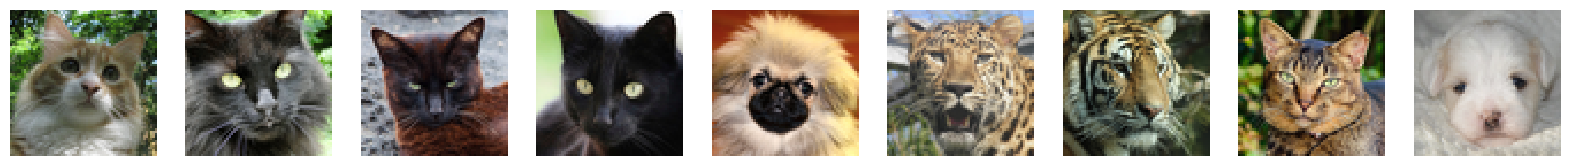

In [7]:
def plot_images(u):
    # Reshape the initial_sample tensor
    images = u.squeeze().cpu().numpy()

    # Display the images
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, image in enumerate(images):
        # black and white images
        if len(images.shape) == 3:
            axes[i].imshow(image, cmap='gray', interpolation='none')
        # colored images
        else:
            # Transpose the image dimensions
            image = np.transpose(image, (1,2,0))
            axes[i].imshow(image, interpolation='none')
        axes[i].axis('off')

    plt.show()
plot_images(eval_batch)

In [8]:
# change dtype to float64
torch.set_default_dtype(torch.float64)
eval_batch = eval_batch.to(torch.float64)

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
def blur_tester(k):
    blurred = heat_forward_module(eval_batch, np.array([k] * eval_batch.shape[0]))
    plot_images(blurred)
    for i in range(len(eval_batch)):
        print("Image", i)
        print(eval_batch[i].mean())
        print(blurred[i].mean())
        print(blurred[i].min(), blurred[i].max())

# control blur tester with interactive slider
slider = widgets.FloatSlider(min=0, max=1, step=0.0001)
widgets.interact(blur_tester, k=slider)

NameError: name 'widgets' is not defined

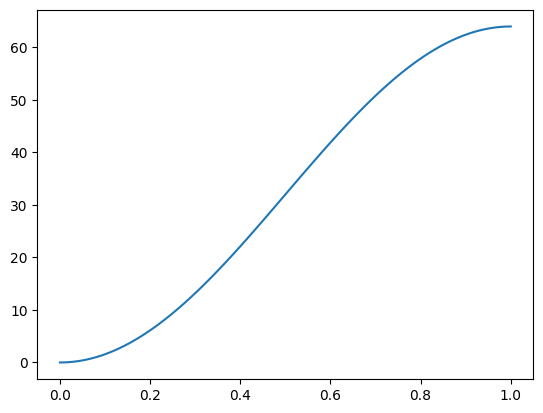

In [ ]:
# experiment with continuous timestep schedule
def blur(t):
    return 64 * np.sin(t * np.pi / 2)**2

t = np.linspace(0, 1, 100)
plt.plot(t, blur(t))

/var/folders/5s/h912v31x5gj935j3y2b1s3040000gn/T/ipykernel_25785/2232604193.py:2: RuntimeWarning: divide by zero encountered in divide
  return x / (1 - x)**4


(0.0, 64.0)

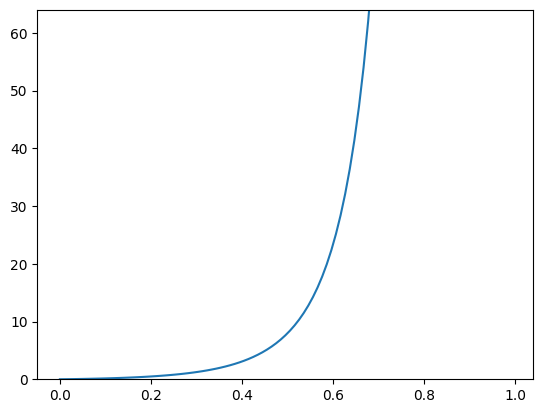

In [ ]:
def f(x):
        return x / (1 - x)**4
    
t = np.linspace(0, 1.0, 100)
plt.plot(t, f(t))
plt.ylim(0, 64)

(array([13.,  3.,  4.,  3.,  4.,  1.,  1.,  0.,  3.,  1.,  3.,  1.,  0.,
         2.,  3.,  0.,  1.,  0.,  1.,  1.,  1.,  2.,  0.,  0.,  0.,  3.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.86810919e-02, 6.52404945e-01, 1.28612880e+00, 1.91985265e+00,
        2.55357650e+00, 3.18730036e+00, 3.82102421e+00, 4.45474806e+00,
        5.08847192e+00, 5.72219577e+00, 6.35591962e+00, 6.98964348e+00,
        7.62336733e+00, 8.25709118e+00, 8.89081503e+00, 9.52453889e+00,
        1.01582627e+01, 1.07919866e+01, 1.14257104e+01, 1.20594343e+01,
        1.26931582e+01, 1.33268820e+01, 1.39606059e+01, 1.45943297e+01,
  

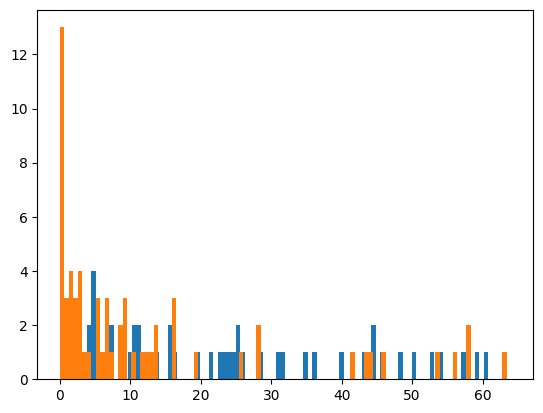

In [ ]:
# sample random distances in f
a = np.random.uniform(0.05, 1, 64)
# replace max a with 1
a[a.argmax()] = 1
b = np.random.uniform(0, a)
dist = blur(a) - blur(b)
plt.hist(dist, bins=100, range=(0, 64))
dist.min()
plt.hist(blur(b), bins=100)

/var/folders/5s/h912v31x5gj935j3y2b1s3040000gn/T/ipykernel_25785/2232604193.py:2: RuntimeWarning: divide by zero encountered in divide
  return x / (1 - x)**4


(array([27.,  9.,  2.,  1.,  1.,  0.,  0.,  1.,  2.,  1.,  1.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

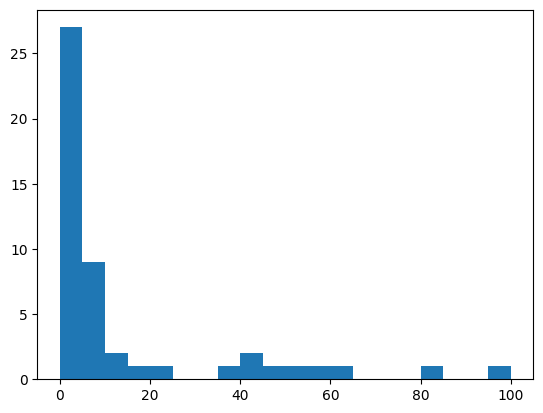

In [ ]:
# plot hist of f(a)
plt.hist(f(a), bins=20, range=(0, 100))

In [ ]:
a

array([0.53709798, 0.71701624, 0.42467843, 0.32734773, 1.        ,
       0.17404791, 0.13016493, 0.15154685, 0.5816397 , 0.45067621,
       0.4846598 , 0.31797615, 0.26193262, 0.45221602, 0.93221969,
       0.19709438, 0.49170902, 0.45830146, 0.84161508, 0.24837187,
       0.83180193, 0.20439194, 0.79302208, 0.20869407, 0.51945213,
       0.97751885, 0.85769336, 0.44165402, 0.7068178 , 0.90547304,
       0.4907056 , 0.19688445, 0.5965692 , 0.3418462 , 0.31533613,
       0.13424123, 0.64559574, 0.76573885, 0.41294139, 0.8357775 ,
       0.13267907, 0.18622132, 0.50080166, 0.15350566, 0.66935696,
       0.66618918, 0.08687141, 0.76880986, 0.55320606, 0.64335267,
       0.17973976, 0.11941136, 0.67544911, 0.69837239, 0.45243202,
       0.8862298 , 0.46660681, 0.27256153, 0.23143123, 0.97928696,
       0.76566535, 0.65552692, 0.08500632, 0.64923018])

In [ ]:
a = np.random.rand(100)
(1 - a.max())**100 * 0.8

9.298087028114019e-268